# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Random Forest Classifier

In [3]:
# Function to convert only numeric columns to float32
def convert_to_float32(col):
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(col):
        return col.astype('float32')  # Convert to float32
    else:
        return col  # Return the column as is if not numeric

def train_random_forest_cls(events, num_train_sample = None):
    data = events.copy(deep=True)
    
    # Separate features and target
    X = data.iloc[:, :-1]  # All columns except the last one
    y = data.iloc[:, -1]   # Last column (target)

    # One-hot encode categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Encode target variable to map ["Normal traffic", "Suspicios traffic", "DDoS attack"] to [0, 1, 2]
    if y.dtype == 'object':
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

    # Convert nuemrical values to to float32
    X = X.apply(convert_to_float32)

    # Split the datatset into training and testing sets
    if num_train_sample:
        X_train = X[:num_train_sample]
        y_train = y[:num_train_sample]
        X_test = X[num_train_sample:]
        y_test = y[num_train_sample:]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=40)
    clf.fit(X_train, y_train)
    
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    importances = clf.feature_importances_
    feature_names = X.columns  # Get feature names

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

    # Group the importances for features that start with "Attack code_"
    attack_code_columns = [col for col in feature_names if col.startswith("Attack code_")]

    # Filter out the Attack code features from the original feature importance DataFrame
    attack_code_importance = feature_importance_df[feature_importance_df["Feature"].isin(attack_code_columns)]["Importance"].sum()

    # Create a new entry for "Attack code" with the combined importance
    new_feature = pd.DataFrame({"Feature": ["Attack code"], "Importance": [attack_code_importance]})

    # Remove the original "Attack code_" features
    feature_importance_df = feature_importance_df[~feature_importance_df["Feature"].isin(attack_code_columns)]

    # Add the new "Attack code" row
    feature_importance_df = pd.concat([feature_importance_df, new_feature], ignore_index=True)

    # Sort by importance again
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Print the top features
    print(feature_importance_df)
    
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Overall accuracy: {accuracy:.2f}")

    
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"Accuracy for class '{class_name}': {class_accuracy[i]:.2f}")
        
    # Calculate F1 score (macro-average for the whole dataset)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"Macro-average F1 score: {f1_macro:.2f}") # This should be the important metric (F1 for each class and just averages those)
    print(f"Micro-average F1 score: {f1_weighted:.2f}")
    
    # Calculate F1 score for each class
    f1_scores = f1_score(y_test, y_pred, average=None)
    for class_name, f1 in zip(label_encoder.classes_, f1_scores):
        print(f"F1 score for class '{class_name}': {f1:.2f}")

    # For ROC-AUC, binarize the output (One-vs-Rest approach)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust based on the number of classes
    y_pred_prob = clf.predict_proba(X_test)

    # Calculate ROC-AUC (macro-average for the whole dataset)
    roc_auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")
    roc_auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average="micro", multi_class="ovr")
    print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")
    print(f"Micro-average ROC-AUC: {roc_auc_micro:.2f}")

    # Plot ROC curve for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:,0], y_pred_prob[:,0])
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_macro:.2f}", c="green")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_prob[:, 0])  # For 'Normal traffic'
    # plt.plot(fpr, tpr, label=f"Normal traffic (AUC = {roc_auc_macro:.2f})")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_pred_prob[:, 1])  # For 'Suspicious traffic'
    # plt.plot(fpr, tpr, label=f"Suspicious traffic (AUC = {roc_auc_macro:.2f})")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 2], y_pred_prob[:, 2])  # For 'DDoS attack'
    # plt.plot(fpr, tpr, label=f"DDoS attack (AUC = {roc_auc_macro:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format="d")
    plt.imshow(np.log1p(cm), cmap='Blues')  # Log transform for better visualization
    plt.show()

### Example usage

                                              Feature  Importance
5                                 Avg source IP count    0.118529
17                                     Packet Density    0.103370
3                                          Data speed    0.098750
0                                         Port number    0.073449
15                              Source IP Burst Ratio    0.071121
13                             Data Speed Burst Ratio    0.059944
18                             Packet Size Efficiency    0.056856
2                                        Packet speed    0.053770
4                                      Avg packet len    0.052554
16                           Packet Transmission Rate    0.045716
14                         Avg Packet Len Burst Ratio    0.041282
35  Inferred Attack Code_Generic UDP; SYN Attack; ...    0.037712
6                                            Duration    0.034125
12                           Packet Speed Burst Ratio    0.029333
11        

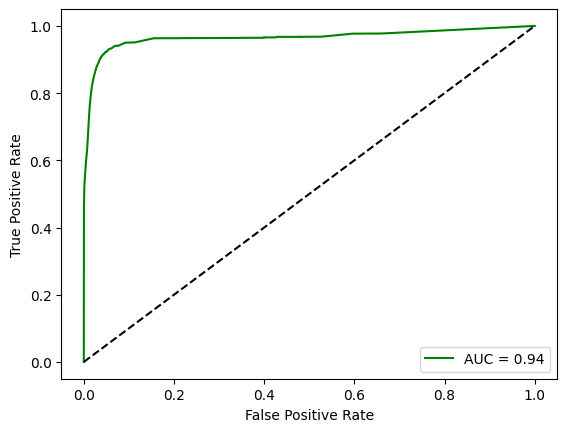

<Figure size 800x600 with 0 Axes>

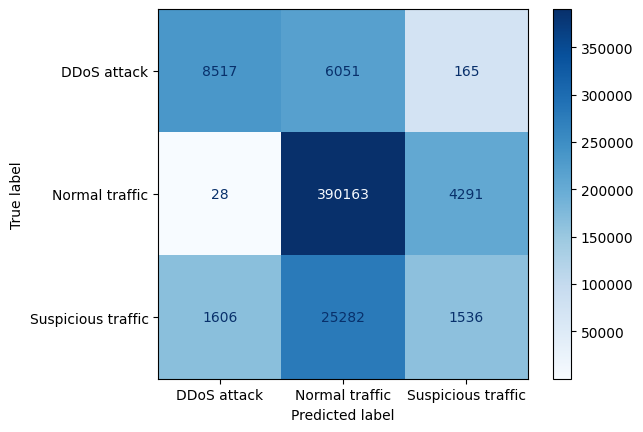

In [ ]:
events_train = pd.read_csv("/home/appuser/data/train/A_B_inferred_attack_code.csv")
events_test = pd.read_csv("/home/appuser/data/gen/D_inferred_attack_code.csv")

events_combined = pd.concat([events_train, events_test])
num_train_sample = events_train.shape[0]

train_random_forest_cls(events_combined, num_train_sample)